In [135]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

palette = cc.glasbey_hv

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [226]:
# load the data from the xlsx file
df = pd.read_excel('../lc-project-data/2024-04-09-DATASET-ML.xlsx')


In [227]:
df.shape
from copy import deepcopy

preserved_df = deepcopy(df)
preserved_df.shape

(5801, 692)

## QA

In [228]:
# which columns are all nan?
nan_cols = preserved_df.columns[preserved_df.isna().all()].tolist()

In [229]:
# drop all columns that are fully NaN
df = df.dropna(axis = 1, how = "all")
df.shape

(5801, 669)

In [230]:
# adjunctive columns - remove adj2-adj10 as they are all zeroes
adj_cols = [col for col in preserved_df.columns if 'adj' in col]

adj_cols

['adjunctive___1',
 'adjunctive___2',
 'adjunctive___3',
 'adjunctive___4',
 'adjunctive___5',
 'adjunctive___6',
 'adjunctive___7',
 'adjunctive___8',
 'adjunctive___9',
 'adjunctive___10']

In [231]:
to_drop = []

# drop gender column - mostly NaN
to_drop.append("gender")

# drop other_hhx4 to other_hhx10 -  zeroes
# to_drop.extend([f"other_hhx{i}" for i in range(4, 11)])


In [232]:
try:
    df = df.drop(columns = to_drop)
except KeyError:
    pass
    # logging.error(f"Error: {e}")
df.shape

(5801, 668)

In [233]:
# get all column names
df_columns = df.columns

# FEATURE SETS

## DEMO + HX

In [234]:
# record id
RECORDS = ["record_id"]

# demographics etc
DEMOGRAPHICS = ["sex", "age", "home_location", "living_with", "number_of_persons_in_house"]
GEOGRAPHY = ["country"]
EMPLOYMENT = ["employed", "occupation", "hcp", "micro"]
SITES = ["dag"]

# substances
SUBSTANCES = [col for col in df_columns if "substances___" in col]

# find all columns with hhx in the name
HEALTH    = ["global"]
HEALTH_HX = [col for col in df_columns if "past_hhx" in col]

# medications
# use a regexp to find all columns with medication followed by a number?
MEDICATIONS = [col for col in df_columns if "medication" in col]
# drop medications that have a ___ in the name
MEDICATIONS = [med for med in MEDICATIONS if "___" not in med]

# surveys
GAD    = [col for col in df_columns if "_gad" in col]
PROMIS = [col for col in df_columns if "promis29" in col]
PHQ    = [col for col in df_columns if "phq" in col]

# remove gad_complete from GAD
GAD = [gad for gad in GAD if "complete" not in gad]



# completeness
PHX_COMPLETE    = ["phx_complete"]
PROMIS_COMPLETE = [col for col in df_columns if "promis_29_profile" in col]
PHQ_COMPLETE    = [col for col in df_columns if "patient_health_questionaire" in col]



### Medications - one hot encoding

In [235]:
df[MEDICATIONS]

,medication1,medication2,medication3,medication4,medication5,medication6,medication7,medication10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5797,29.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN
5798,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
# read medications dict from json
import json

with open("./OUTPUT/dict-medications.json", "r") as f:
    medication_dict = json.load(f)

# cast key to int
medication_dict = {int(k): v for k, v in medication_dict.items()}

In [237]:

print(f">>> constructing binary columns for each unique medication")
# get all of the unique values in the medication columns
all_meds = df[MEDICATIONS].values
# drop the empty strings from the_vals
all_meds = [[val for val in row if val != ""] for row in all_meds]

# fill nans with 0
all_meds = [[val if val == val else 0 for val in row] for row in all_meds]

# count the unique values in all_meds
unique_meds = np.unique(np.concatenate(all_meds))

print(f">>> \t- will add    {len(unique_meds):>4d} NEW columns")
print(f">>> \t- will remove {len(MEDICATIONS):>4d} OLD columns")
print(f">>> \t- net change  {len(unique_meds) - len(MEDICATIONS):>4d} columns")

# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the hx_df index as the index

encoded_meds = mlb.fit_transform(all_meds)
column_names = [f"meds_{med}" for med in mlb.classes_]
med_df = pd.DataFrame(encoded_meds, columns=column_names, index=df.index)

med_df.shape


# TODO:
# - use the med dict mapping for column names
# - drop the meds_0 column
#  - drop the original meds columns

>>> constructing binary columns for each unique medication
>>> 	- will add      28 NEW columns
>>> 	- will remove    8 OLD columns
>>> 	- net change    20 columns


(5801, 28)

In [238]:
# drop the meds_0 column
try:
    med_df = med_df.drop(columns = "meds_0")
except KeyError:
    pass

# rename the columns using the medication_dict

for c in med_df.columns:

    # get the medication number from the column name
    mn = int(float(c.split("_")[1]))

    # look up the medication name in the medication_dict
    med_name = "MED-" + str.replace(medication_dict[mn], " ", "-")

    # rename the column
    med_df = med_df.rename(columns = {c: med_name})

med_df

,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,MED-Antiparasitics,MED-Antiparkinson-agents,MED-Antipsychotics,...,MED-Hormonal-agents-(adrenal),MED-Hormonal-agents-(sex-hormones),MED-Hormonal-agents-(thyroid),MED-Hormone-suppressant-(thyroid),MED-Immunological-agents,MED-Inflammatory-bowel-disease-agents,MED-Metabolic-bone-disease-agents,MED-Ophthalmic-agents,MED-Respiratory-tract-agents,MED-Skeletal-muscle-relaxants
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5797,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5798,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
# drop the original meds columns
# df = df.drop(columns = MEDICATIONS)

# concatenate the med_df with the original df
df = pd.concat([df, med_df], axis = 1)

# new name for medications
MEDICATIONS = med_df.columns.tolist()


In [240]:
df.shape

(5801, 695)

### Health HX - Diagnoses

In [241]:
# load a list of past hhx diags from the json file in OUTPUT

import json

with open("./OUTPUT/dict-past-hhx.json", "r") as f:
    past_hhx_dict = json.load(f)

# cast the key to an int
past_hhx_dict = {int(k): v for k, v in past_hhx_dict.items()}

In [255]:
# rename the past_hhx columns in df
for c in HEALTH_HX:

    # get the past_hhx number from the column name
    hhx = int(c.split("_")[-1])

    # look up the past_hhx name in the past_hhx_dict
    hhx_name = "HHX-" + str.replace(past_hhx_dict[hhx], " ", "-")
    print (hhx_name)

    # rename the column
    df = df.rename(columns = {c: hhx_name})


HEALTH_HX = [col for col in df.columns if "HHX" in col]

HHX-Arterial-Hypertension
HHX-Pulmonary-hypertension
HHX-Cardiovascular-disease
HHX-Diabetes
HHX-Cancer
HHX-Immunosuppression
HHX-Chronic-lung-disease
HHX-Chronic-kidney-disease
HHX-Dialysis
HHX-Chronic-liver-disease
HHX-Obesity
HHX-Pregnant
HHX-Transient-ischemic-attack-(TIA)
HHX-Chronic-neurological-disorder-(other-than-stroke/TIA)
HHX-Stroke
HHX-Dementia
HHX-HIV-or-AIDS
HHX-Atrial-fibrillation-or-flutter
HHX-Prior-myocardial-infarction
HHX-Heart-failure
HHX-Coronary-artery-disease
HHX-Chronic-hematologic-disease
HHX-Malnutrition
HHX-COPD-(emphysema
HHX-Psychiatric-disease
HHX-Asthma
HHX-Rheumatologic-disease
HHX-Past-tuberculosis-infection
HHX-Other


### LC+, LC-, HC

In [256]:
# LC_positive types
pos_vals = [2,4,6,8,9,12,13]
neg_vals = [1,5,7,10,]
hc_vals  = [3,11, 14,15]

LC_pos = df.query('participant_type in @pos_vals')
LC_neg = df.query('participant_type in @neg_vals')
HC = df.query('participant_type in @hc_vals')


df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC')

df['LC_STATUS'].value_counts()

LC_STATUS
LC_NEG    3259
LC_POS    2461
HC          81
Name: count, dtype: int64

## SITES

In [257]:
site_name_dict = {1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                    4: 'RIO',
                    5: 'LUN',
}

In [258]:
# make a pivot table of the LC_STATUS by SITE
lc_site = df.pivot_table(index = 'dag', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

# map the dag index to the site name
lc_site.index = lc_site.index.map(site_name_dict)


lc_site

LC_STATUS,HC,LC_NEG,LC_POS
dag,,,
LDN,31,178,110
MTL,0,1997,916
SAN,3,71,227
RIO,9,128,659
LUN,38,885,549


## Full history

In [259]:
# add up the health history information
HX = HEALTH_HX + MEDICATIONS + GAD + PROMIS + PHQ

# for each column in HX, check if there are values that are just spaces
for col in HX:
    # are any of the values just spaces?
    if df[col].apply(lambda x: isinstance(x, str) and x.isspace()).any():
        print(f"Column {col} has spaces")

        # remove the spaces and replace with blank
        # df[col] = df[col].apply(lambda x: np.nan if isinstance(x, str) else x)

# for each column in HX, check if there are values that are just spaces



<Axes: >

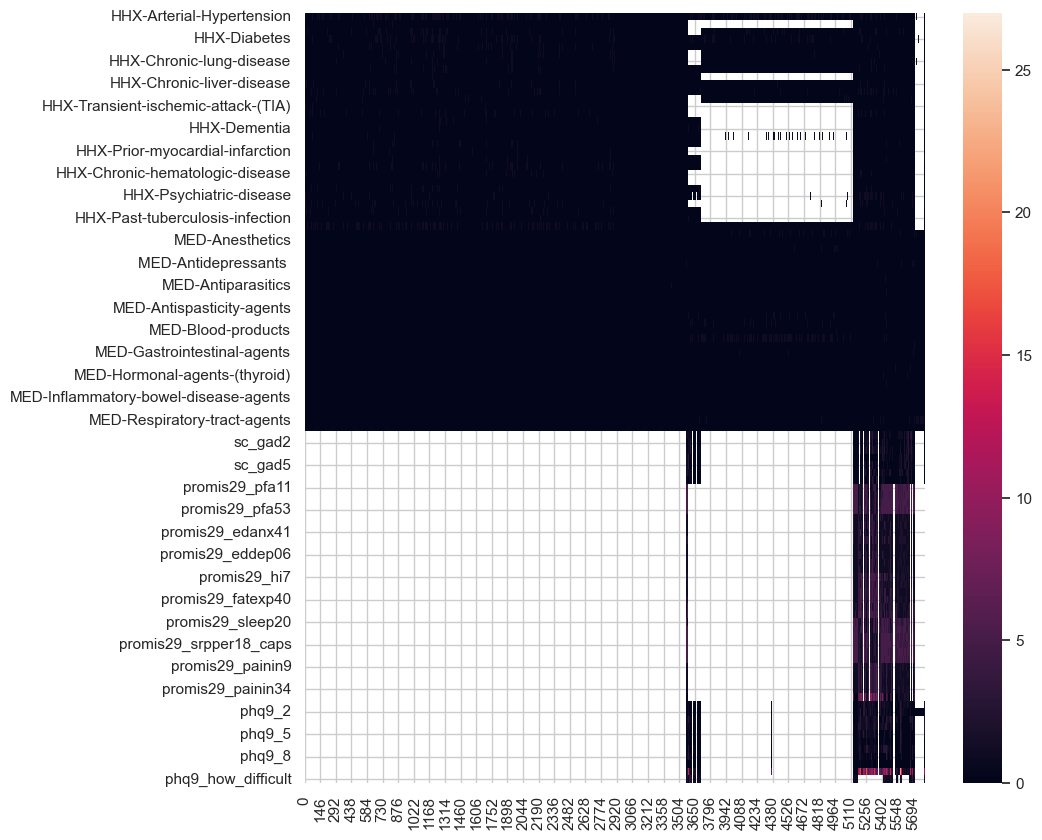

In [260]:
# plot it as a heatmap

import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df[HX].T, cbar=True, ax = ax)


In [305]:
# how many nulls per site?
df.groupby('dag')[HX].apply(lambda x: x.isnull().sum()).T


dag,1,2,3,4,5
HHX-Arterial-Hypertension,60,0,0,0,0
HHX-Pulmonary-hypertension,81,0,0,121,1427
HHX-Cardiovascular-disease,74,0,0,121,0
HHX-Diabetes,66,0,0,0,0
HHX-Cancer,76,0,0,0,0
...,...,...,...,...,...
phq9_7,103,2913,16,684,1420
phq9_8,103,2913,16,684,1420
phq9_9,103,2913,16,684,1420
phq9_total_score,103,2913,16,684,1420


## CLINICAL TESTS


In [263]:

s = "igg	wbc	neutrophil	neutrophil_count	lymphocyte	lymphocyte_count	monocyte	monocyte_count	eosinophil	eosinophil_count	basophil	basophil_count	platelets	haemoglobin	urea	creatinine	ntprobnp	bnp	sodium	potassium	crp	ldh	cpk	albumin		ast	alt	pct	troponinthigh	troponinihigh	troponint	troponini	aptt	inr	triglycerides	bilirubin	bilirubin_direct	glucose	fibrinogen	ferritin	il6	cd4	cd8	angiography	pocus	echocardiogram	echoresult	ekg	ekgresult	ekgcode	stented	cxr	cxrresult	cxrcode	cta	ctaresult	ctt	cttresult	cth	cthresult	imaging_results	imaging	spirometry	spirometryresult	metacholine	lung_function	lung_functionresult"
words = s.split()
words.sort()
CLINICAL_TESTS = words

# remove imaging_results from the list
CLINICAL_TESTS.remove("imaging_results")


CLIN_TESTS_COMPLETE = [col for col in df_columns if "clinical_tests_complete" in col]

In [309]:
# remove columns that have less than 200 non-null points
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if df[col].count() > 200]

# drop features starting with ctt and cx
CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg"))]



<Axes: >

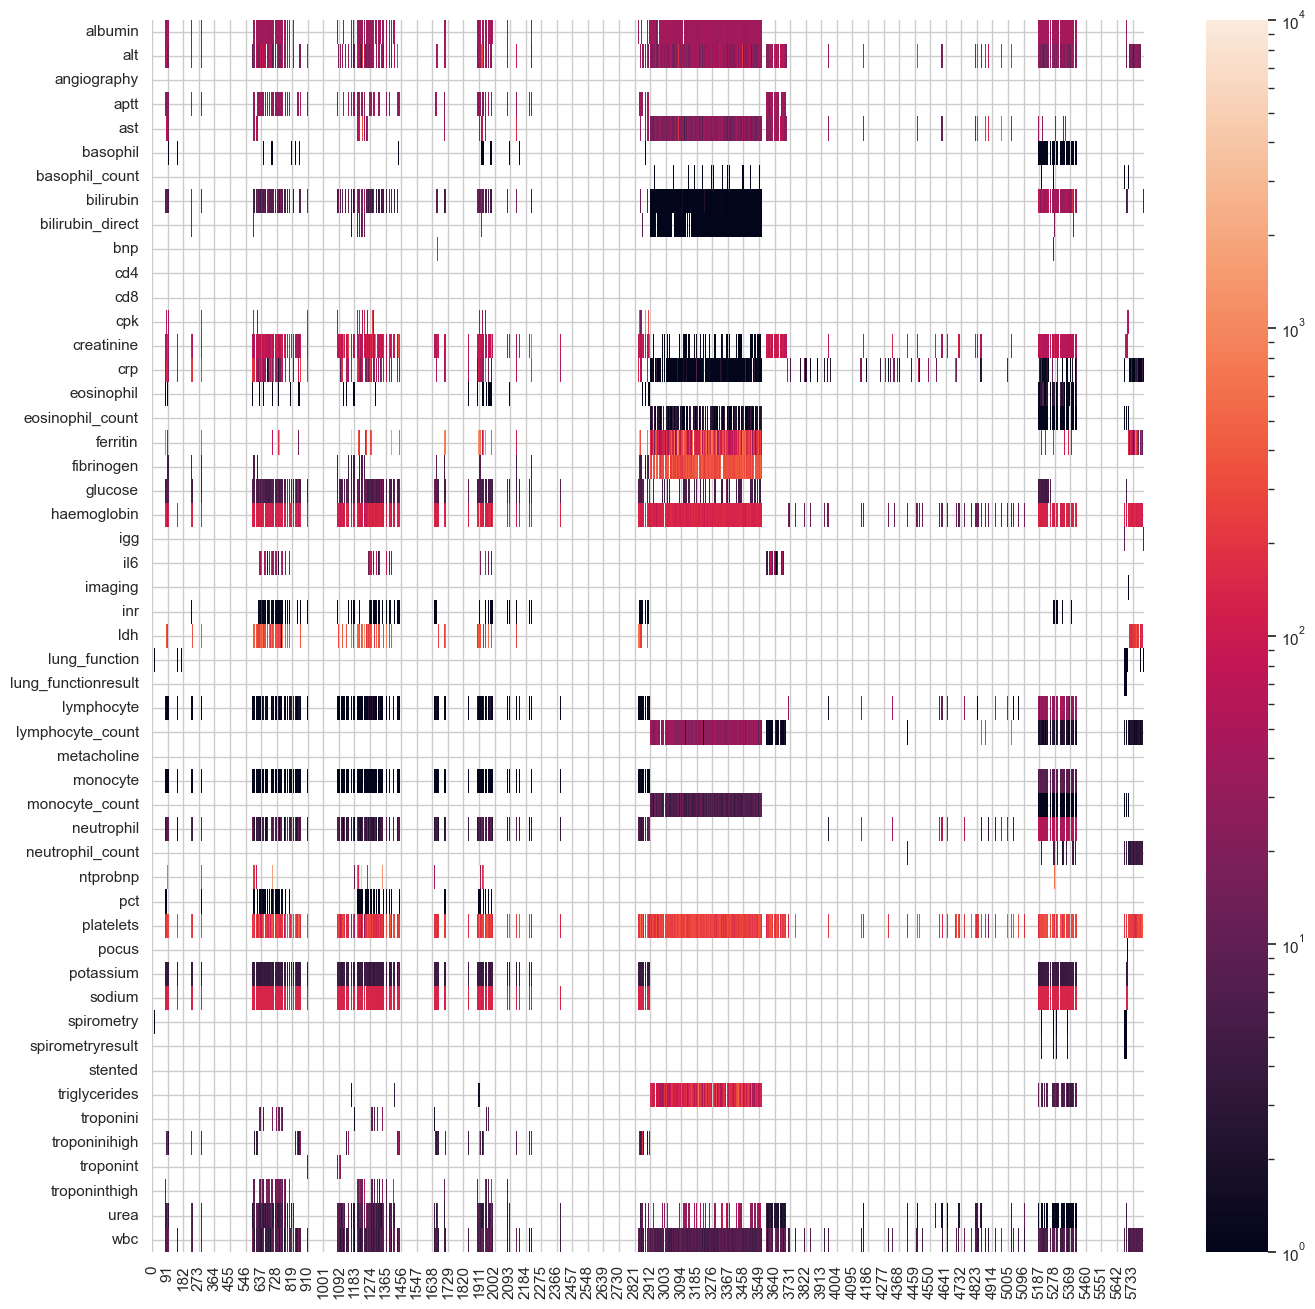

In [310]:
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(df[CLINICAL_TESTS].T, cbar=True, ax = ax, norm = norm)

In [311]:
# count nans by LC_STATUS
df.groupby('LC_STATUS')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).T



LC_STATUS,HC,LC_NEG,LC_POS
albumin,81,2976,1390
alt,81,2764,1238
angiography,81,3257,2456
aptt,81,2903,2237
ast,81,2982,1683
basophil,81,3058,2094
basophil_count,81,3257,1623
bilirubin,81,2948,1339
bilirubin_direct,81,3226,1791
bnp,81,3255,2447


In [314]:
from project_modules.data_prep import treat_outliers

b = treat_outliers(df[CLINICAL_TESTS], z_threshold = 3, method = "median")


df[CLINICAL_TESTS] = b

>>> Using z-threshold = 3.00 to identify outliers.
>>> There are 474 outliers in the data for abs(z) ≥ 3.00.
>>> Outliers are 8.17% of the total data.
>>> Replacing outliers with median.


/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/david/projects/lc2/project_modules/data_prep/_treat_outliers.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].mask(outlier_mask[col], median[col])


In [316]:
# sklearn median imputer

from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')

# clinical_test_features = df[CLINICAL_TESTS].copy()
clinical_test_features =b.copy()

ctf_imputed = pd.DataFrame(imp.fit_transform(clinical_test_features), columns = clinical_test_features.columns)

print(ctf_imputed.shape)

(5801, 51)


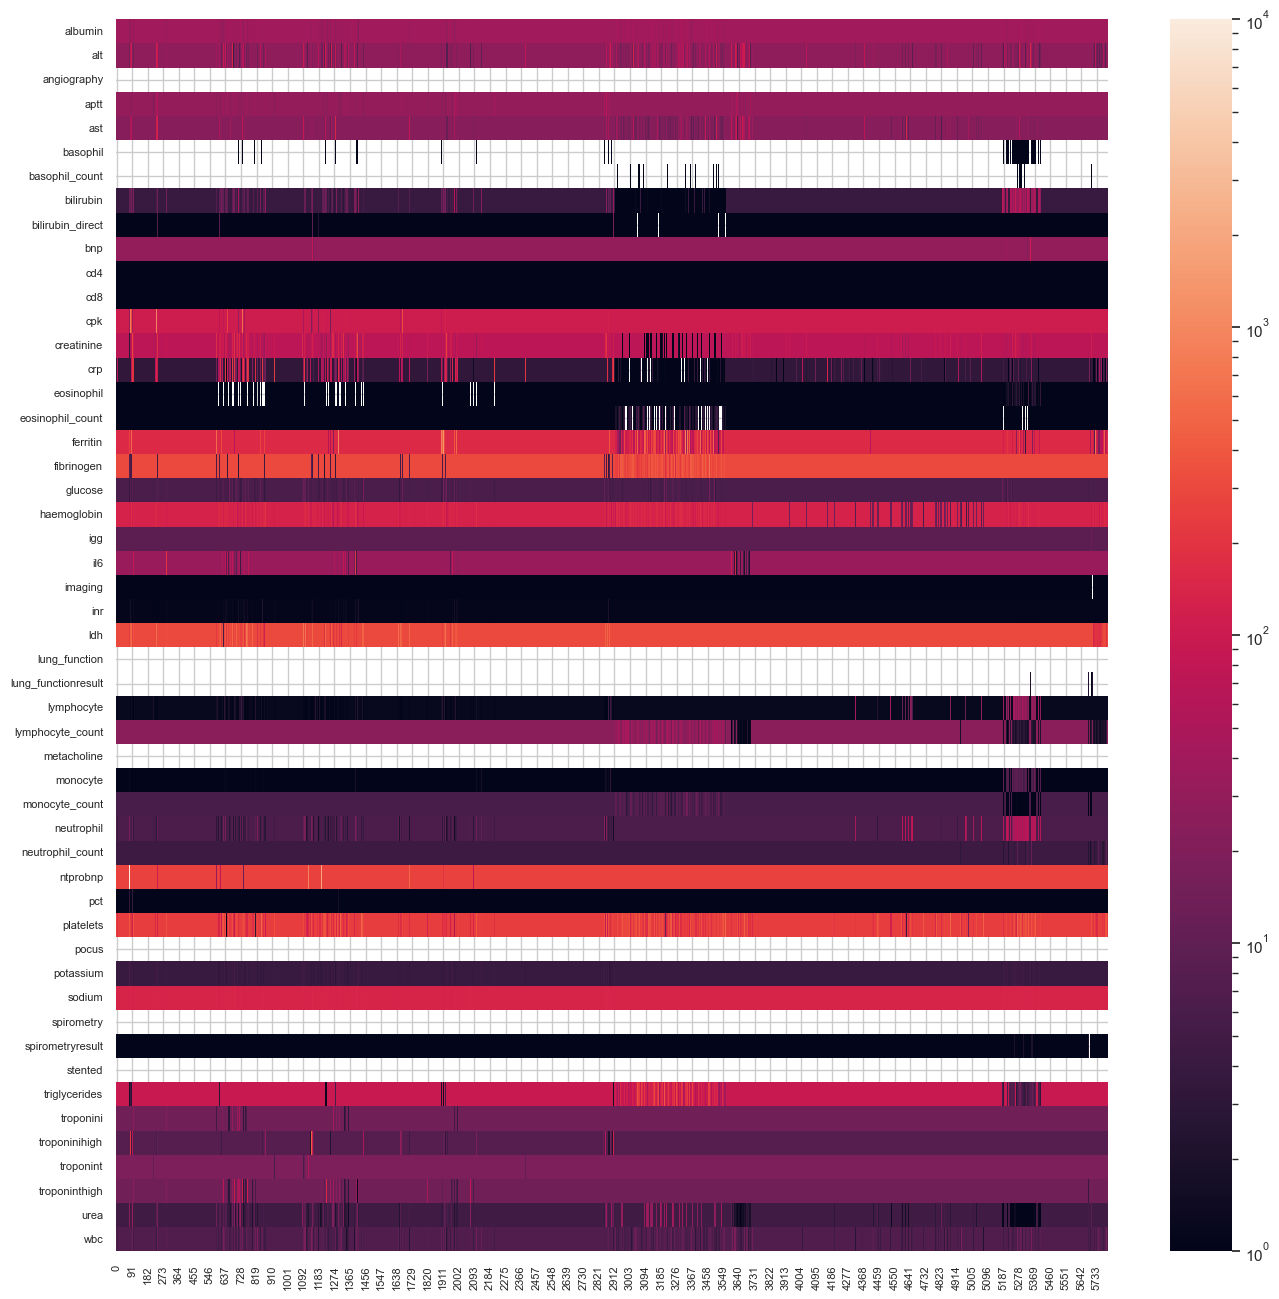

In [317]:
# plot the heatmap
fig, ax = plt.subplots(figsize=(16, 16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(ctf_imputed.T, cbar=True, ax = ax, norm = norm)
# set text size smaller
plt.xticks(fontsize=8); plt.yticks(fontsize=8);


## VACCINES

In [318]:
VAX_STATUS = ["vaccinated"]


# given a list of substrings, find aall columns that contain the substrings
def find_columns(df_columns, substrings):
    return [col for col in df_columns if any(substring in col for substring in substrings)]

VAX = find_columns(df_columns, ["astra_zeneca", "pfizer", "moderna", "j_j", "sinoppharm", "sinovac", "sputnik", "other___"])

VAX_SIDE_EFFECTS = find_columns(df_columns, ["vac_sideeffect"])

# fill in the missing values with 0
df[VAX] = df[VAX].fillna(0)

vax_features = df[VAX]

In [319]:
vax_features.shape, ctf_imputed.shape

((5801, 70), (5801, 51))

<Axes: >

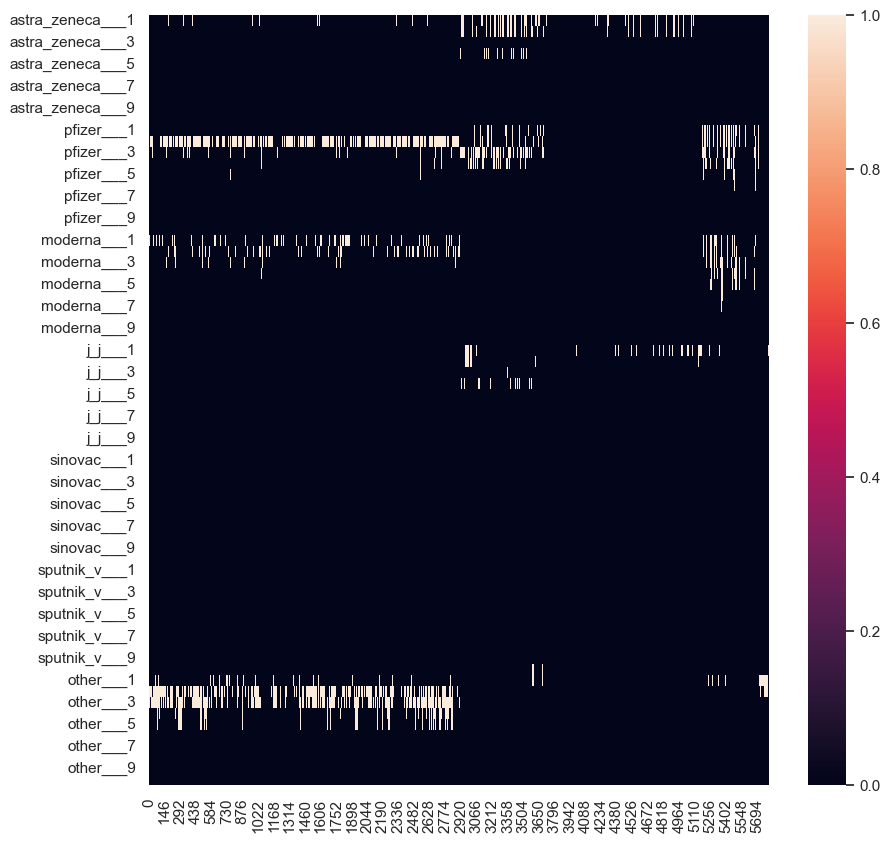

In [320]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df[VAX].T, cbar=True, ax = ax, )

## PARTICIPANT TYPES

In [321]:
df['participant_type'].value_counts()

participant_type
7     1778
6     1607
10    1147
13     493
5      327
4      242
8       84
11      43
3       38
2       35
1        7
Name: count, dtype: int64

In [322]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

LC_STATUS,HC,LC_NEG,LC_POS
participant_type,,,
1,0,7,0
2,0,0,35
3,38,0,0
4,0,0,242
5,0,327,0
6,0,0,1607
7,0,1778,0
8,0,0,84
10,0,1147,0


## CLUSTERING

In [344]:
# feature_set = ttt_imputed.join(vax_features)

hx_features = df[HEALTH_HX]
meds_features = df[MEDICATIONS]


feature_set = ctf_imputed#.join(hx_features).join(meds_features)



# feature_set = vax_features

feature_set.shape

(5801, 51)

In [345]:
# clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from hdbscan import HDBSCAN
from umap import UMAP

hdb_   = HDBSCAN(
                    min_cluster_size=50, 
                     min_samples=5,
                     cluster_selection_epsilon=0.5,
                     )
umap_  = UMAP(n_components=2,
              spread = 10.0,)
scaler = MinMaxScaler().set_output(transform = "pandas")

In [346]:
X = scaler.fit_transform(feature_set.loc[LC_pos.index])
X = X.dropna()
X.shape

(2461, 51)

In [347]:
# umap
X_umap = umap_.fit_transform(X)

# cluster
hdb_.fit(X_umap);

/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [348]:
X_umap.shape

(2461, 2)

In [349]:
# make a plotting dataframe
plot_df = pd.DataFrame(X_umap, columns = ["x", "y"], index = X.index)
plot_df["hdb_cluster"] = hdb_.labels_

plot_df["Site"] = LC_pos["dag"].map(site_name_dict)


In [350]:
plot_df

,x,y,hdb_cluster,Site
0,49.231354,49.029156,1,MTL
1,54.445641,44.384666,1,MTL
2,51.546970,48.926342,1,MTL
3,51.265526,48.617290,1,MTL
4,54.822678,46.363014,1,MTL
...,...,...,...,...
5794,-2.596136,23.430813,4,LDN
5797,25.881397,5.985854,6,LDN
5798,50.214588,39.547501,1,LDN
5799,49.064087,57.069046,1,LDN


In [351]:
# get the centroids of the umap coordinates by cluster

centroids = pd.DataFrame(X_umap, columns = ["x", "y"]).assign(cluster = hdb_.labels_).groupby("cluster").mean()


/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_92886/3032324687.py:5: UserWarning: The palette list has more values (256) than needed (7), which may not be intended.
  sns.scatterplot(


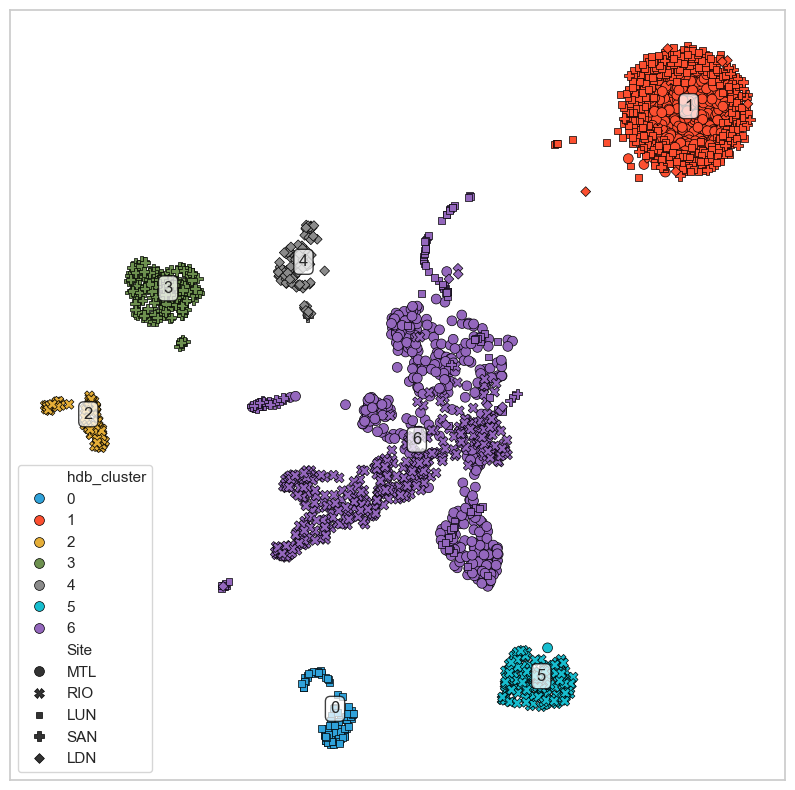

In [352]:
# plot the clusters

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
                data = plot_df, 
                x = "x", 
                y = "y", 
                hue = "hdb_cluster", 
                style = "Site",
                s=50, 
                palette = palette, 
                edgecolor='black', 
                linewidth=0.5, 
                # alpha = 0.125,
                ax = ax, 
                )

# make legend points larger
plt.legend(markerscale=1)

for i, centroid in centroids.iterrows():
    plt.annotate(
                    i, 
                    (centroid["x"], centroid["y"]),
                    bbox=dict(boxstyle="round,pad=0.3", 
                                fc="white", 
                                ec="black", 
                                lw=1, 
                                alpha=0.75)
                )
    
# turn off axis labels and ticks
plt.xticks([]); plt.yticks([]);
plt.xlabel(""); plt.ylabel("");


/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_92886/3071783416.py:15: UserWarning: The palette list has more values (256) than needed (8), which may not be intended.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=hdb_.labels_, s=50, palette = palette)


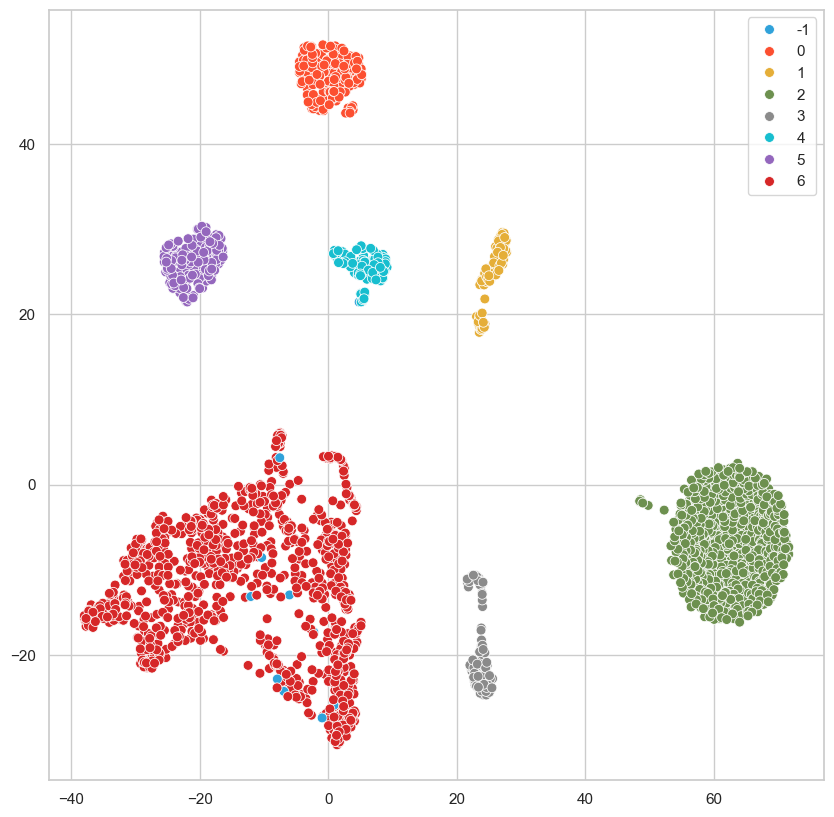

In [365]:
# # another way - cluster first in high-dim space, then reduce to 2D

# # cluster
# hdb_.fit(X)

# # umap
# X_umap = umap_.fit_transform(X, y = hdb_.labels_)



# # plot the clusters

# fig, ax = plt.subplots(figsize=(10, 10))

# sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=hdb_.labels_, s=50, palette = palette)
# # make marker size larger
# plt.legend(markerscale=1)

In [354]:
# augment the LCPOS with the cluster labels
LC_pos.loc[X.index, "cluster"] = hdb_.labels_

# get the cluster centroids

Text(67.25, 0.5, 'Site')

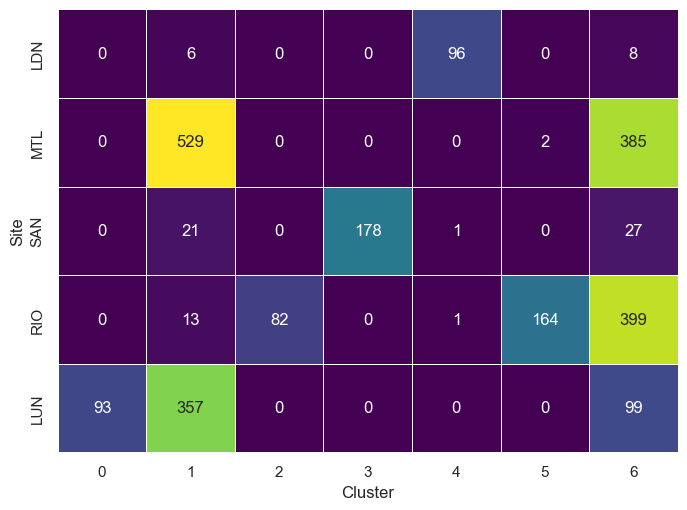

In [355]:

cluster_by_site = LC_pos.groupby("cluster")["dag"].value_counts().unstack().T
# normalize the scale

# convert NaN to 0
cluster_by_site = cluster_by_site.fillna(0).astype(int)

# convert column names to int
cluster_by_site.columns = cluster_by_site.columns.astype(int)


# rename the index to country names
cluster_by_site.index = cluster_by_site.index.map(site_name_dict)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cluster_by_site, robust = True, ax = ax, annot = True, fmt = "d", cmap = "viridis", square = True, linewidths = 0.5, linecolor = "w", cbar = False)

# rename axis labels
plt.xlabel("Cluster")
plt.ylabel("Site")



## EXAMINE THE MEANS

In [356]:
# make a dataferame using the mapped coordinates, cluster labels, and index from the original dataframe
df_umap = pd.DataFrame(X_umap, columns = ["x", "y"], index = X.index)
df_umap["cluster"] = hdb_.labels_

# add the cluster labels to the original dataframe
# df["cluster"] = hdb_.labels_

In [357]:
# save the cluster labels to the original dataframe
X["cluster"] = hdb_.labels_

# get the means by cluster
X.groupby("cluster").mean() 



,albumin,alt,angiography,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,bnp,...,spirometry,spirometryresult,stented,triglycerides,troponini,troponinihigh,troponint,troponinthigh,urea,wbc
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.696970,0.162060,0.0,0.241329,0.150347,0.000000,0.000000,0.045249,0.005650,0.075163,...,0.0,0.500000,0.0,0.203540,0.146667,0.001490,0.150538,0.101852,0.085434,0.271653
1,0.696970,0.148357,0.0,0.241329,0.131397,0.000000,0.000000,0.045334,0.005650,0.075163,...,0.0,0.500540,0.0,0.203540,0.146667,0.001490,0.150538,0.101852,0.088747,0.313337
2,0.707687,0.191896,0.0,0.241329,0.132035,0.000000,1.000000,0.006208,0.006545,0.075163,...,0.0,0.500000,0.0,0.308224,0.146667,0.001490,0.150538,0.101852,0.223072,0.287366
3,0.755192,0.160384,0.0,0.241329,0.139364,0.489567,0.010112,0.458577,0.053101,0.085793,...,0.0,0.525281,0.0,0.044310,0.146667,0.001490,0.150538,0.101852,0.021707,0.338977
4,0.696970,0.132324,0.0,0.240243,0.131218,0.000000,0.007143,0.044960,0.005650,0.077764,...,0.0,0.484694,0.0,0.200791,0.146667,0.001490,0.150538,0.100907,0.088959,0.332870
5,0.717598,0.176642,0.0,0.241614,0.120808,0.000000,0.000000,0.006331,0.007283,0.075163,...,0.0,0.500000,0.0,0.322188,0.146667,0.001490,0.150538,0.107653,0.628633,0.358032
6,0.679187,0.180259,0.0,0.242457,0.145194,0.004202,0.000000,0.060207,0.012481,0.075238,...,0.0,0.498366,0.0,0.232301,0.151227,0.003333,0.152201,0.111131,0.104929,0.331042


In [364]:
# count the nulls in each cluster
X.groupby("cluster").apply(lambda x: x.isnull().sum()).T


cluster,0,1,2,3,4,5,6
albumin,0,0,0,0,0,0,0
alt,0,0,0,0,0,0,0
angiography,0,0,0,0,0,0,0
aptt,0,0,0,0,0,0,0
ast,0,0,0,0,0,0,0
basophil,0,0,0,0,0,0,0
basophil_count,0,0,0,0,0,0,0
bilirubin,0,0,0,0,0,0,0
bilirubin_direct,0,0,0,0,0,0,0
bnp,0,0,0,0,0,0,0


<Axes: xlabel='cluster'>

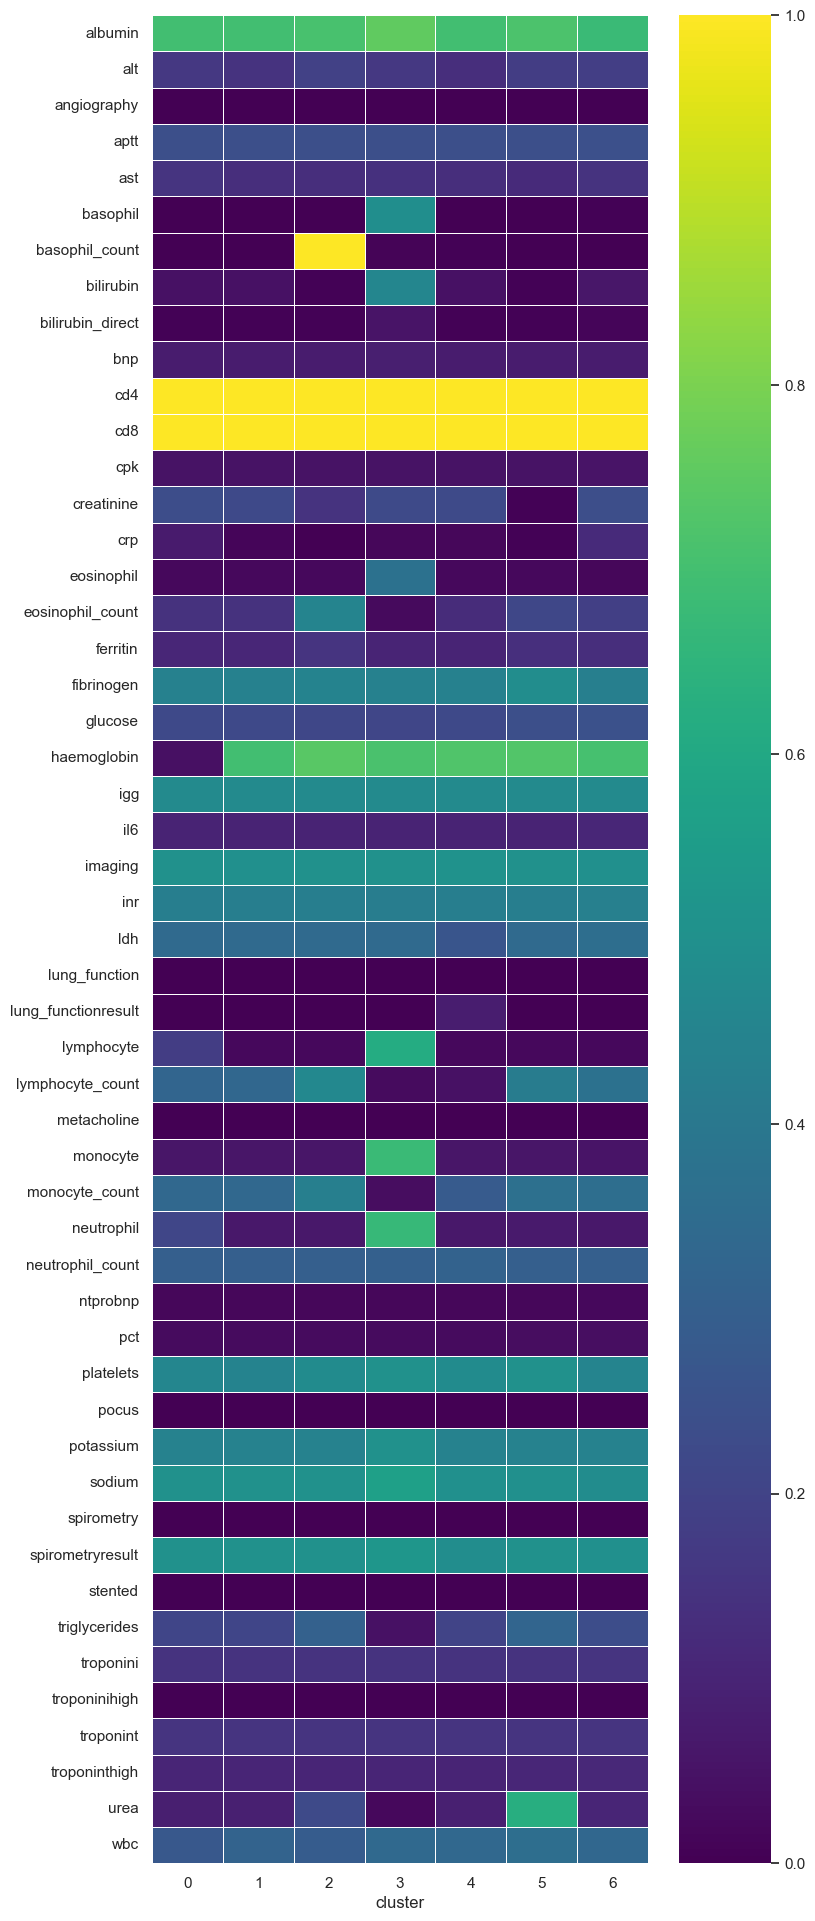

In [358]:
# heatmap of the means by cluster
fig, ax = plt.subplots(figsize=(8,24))

sns.heatmap(X.groupby("cluster").mean().T, robust = True, ax = ax, annot = False, fmt = ".2f", cmap = "viridis", square = False, linewidth = 0.5,)

/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


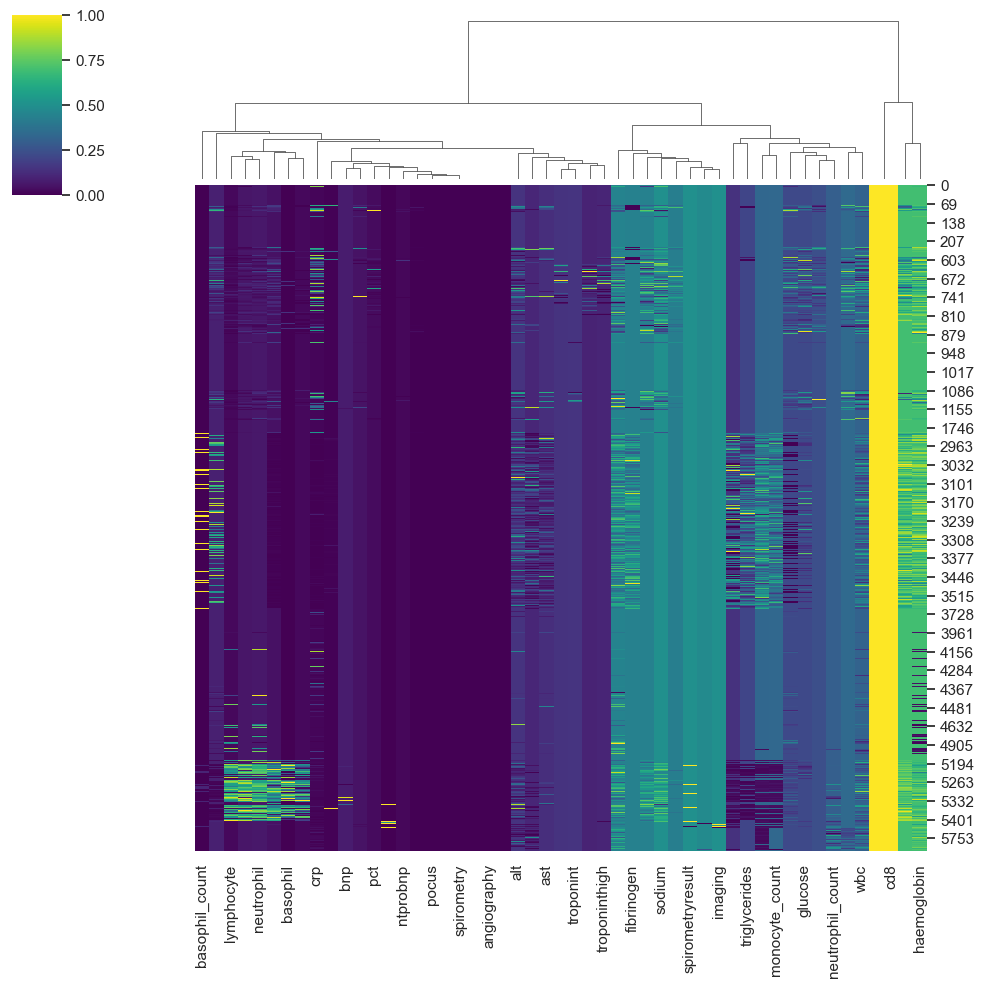

In [359]:
sns.clustermap(X.drop(["cluster"], axis = 1), row_cluster = False, col_cluster = True, cmap = "viridis")

In [360]:
# how many columns in X?
X.shape

(2461, 52)

In [361]:
# # make an array of plots for each column in X
# fig, axs = plt.subplots(7, 6, figsize=(40, 40), layout = "constrained")

# # flatten the axes into a list
# axs = axs.flatten()


# for i, col in enumerate(X.columns):
#     sns.boxplot(data=X, x="cluster", y=col, ax = axs[i])
#     # sns.boxplot(data=X, x="cluster", y=col, ax = axs[i//5, i%5])

#     # set the title as the column name
#     axs[i].set_title(col)
#     # axs[i//5, i%5].set_title(col)

#     # turn off the y axis label
#     axs[i].set_ylabel("")
#     axs[i].set_xlabel("")
    

# # # plot the clusters
# # fig, ax = plt.subplots(figsize=(10, 10))

# # sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=hdb_.labels_, s=10, palette = palette)

## CLINICAL NOTES

In [362]:
# notes = df["clinical_note"].dropna()
# notes.shape

# # should use a clinical language model to do topic modelling here
# # for now, just clean the text


# # clean the text by stripping whitespace, punction, tabs, and newlines
# notes = notes.str.strip().str.replace(r'[^\w\s]', '').str.replace(r'\s+', ' ', regex=True)

# # save the notes as a dataset
# notes.to_csv("./OUTPUT/clinical_notes.csv", index = False)

# # show a sample of the notes
# notes.sample(10)
# # tfidf vectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=1000, stop_words="english")

# X_notes = tfidf.fit_transform(notes)

# X_notes.shape

# X_notes
# # cluster X_notes

# hdb_notes = HDBSCAN(min_cluster_size=50, min_samples=5, cluster_selection_epsilon=0.5)

# hdb_notes.fit(X_notes.toarray())

# # make a dataframe of the umap coordinates
# df_notes_umap = pd.DataFrame(umap_.fit_transform(X_notes.toarray()), columns = ["x", "y"], index = notes.index)

# # add the cluster labels
# df_notes_umap["cluster"] = hdb_notes.labels_

# # add the cluster labels to the original dataframe


# # plot
# fig, ax = plt.subplots(figsize=(10, 10))

# sns.scatterplot(data = df_notes_umap, x = "x", y = "y", hue = hdb_notes.labels_, palette = palette, s = 10, ax = ax)
